In [2]:
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib inline

In [3]:
def net_shape(net):
    return jax.tree_map(lambda x: x.shape, net)

In [4]:
# save_path = "/home/paul/Results/1493061" # no critic
# save_path = "/home/paul/Results/1493081" # bad
save_path = "/home/paul/Results/1099518" 

import jax.numpy as jnp
import json

# Load config
print(save_path + "/config.json")
with open(save_path + "/config.json", "r") as f:
    args = json.load(f)
    # Lists to tuples
    for k, v in args.items():
        if isinstance(v, list):
            args[k] = tuple(v)
    args = argparse.Namespace(**args)
    args.wandb = ""
    print(args)

default = {
    "surrogate_batch": 1024,
    "surrogate": False,
    # "deterministic": True,
    # "es": "cmaes"
}
# Replace missing values with default
for k, v in default.items():
    if not hasattr(args, k):
        setattr(args, k, v)

/home/paul/Results/1099518/config.json
Namespace(env_name='halfcheetah_uni', episode_length=1000, evals=100000, seed=1, policy_hidden_layer_sizes=(128, 128), critic_hidden_layer_sizes=(256, 256), deterministic=True, num_init_cvt_samples=50000, num_centroids=1024, min_bd=0.0, max_bd=1.0, es='canonical', pop=100, es_sigma=1.0, sample_mirror=True, sample_rank_norm=True, adam_optimizer=True, learning_rate=1.0, l2_coefficient=0.02, nses_emitter=False, novelty_nearest_neighbors=10, rl=True, testrl=False, carlies=False, elastic_pull=0, discount=0.99, actor_injection=False, nb_injections=1, critic_training=1000, pg_training=1000, surrogate=True, surrogate_batch=16384, surrogate_omega=0.0, output='/tmpdir/templier/QDax_results/1099518', plot=True, wandb='', tag='fixed_spearman', jobid='1099518', log_period=1, debug=False, logall=True, num_gens=1000, algo='Canonical-Surrogate', config='Canonical 100 - σ 1.0 - lr 1.0  | TD3 1000 - PG 1000  | ω 0.0 (16384)')


In [5]:
from qdax.core.rl_es_parts.es_setup import setup_es
args.algo, args.config

Device count: 1 [GpuDevice(id=0, process_index=0)]


('Canonical-Surrogate',
 'Canonical 100 - σ 1.0 - lr 1.0  | TD3 1000 - PG 1000  | ω 0.0 (16384)')

In [6]:
EM = setup_es(args)

Imported modules
Not doing actor injection


/home/paul/Dev/QDax/qdax/core/rl_es_parts/es_utils.py:266: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = ESRepertoire.init(


layer_shapes [(128,), (18, 128), (128,), (128, 128), (6,), (128, 6)]
sizes [  128  2304   128 16384     6   768]
layer_sizes [128, 2304, 128, 16384, 6, 768]
split_indices [128, 2432, 2560, 18944, 18950]


In [26]:
es = EM.es
env = EM.env
policy_network = EM.policy_network
emitter = EM.emitter
emitter_state = EM.emitter_state
repertoire = EM.repertoire
random_key = EM.random_key
wandb_run  = EM. wandb_run
scoring_fn = EM.scoring_fn


def scores(fitnesses, descriptors) -> jnp.ndarray:
    return fitnesses

emitter.es_emitter

In [8]:
# Load all genomes of offspring
import glob
import re

In [64]:
class Path:
    def __init__(self, file_regex, name=None):
        self.file_regex = file_regex
        self.name = name
        self.files = glob.glob(file_regex)
        # Get last number in each file name
        self.genomes = {}
        self.gens = []
        for f in self.files:
            gen = int(re.findall(r'\d+', f.split("/")[-1])[-1])
            self.genomes[gen] = {"genome": jnp.load(f)}
            self.gens.append(gen)
        self.gens.sort()
        self.projected = None
        self.fitnesses = None

    def __repr__(self):
        return f"Path ({self.name}) with {len(self.genomes)} genomes"

    def __str__(self):
        return self.__repr__()

    def export_genomes(self):
        return jnp.array([self.genomes[g]["genome"] for g in self.gens])

    def transform(self, pca):
        self.projected = pca.transform(self.export_genomes())
        return self.projected

    def plot(self, ax):
        if self.projected is None:
            raise ValueError("No projection computed")
        ax.plot(self.projected[:, 0], self.projected[:, 1], label=self.name)
        ax.scatter(self.projected[-1, 0], self.projected[-1, 1], marker="x")

    def evaluate(self, unflatten_fn, scoring_fn):
        genomes = self.export_genomes()
        nets = unflatten_fn(genomes)
        key = jax.random.PRNGKey(0)
        self.fitnesses, descriptors, extra_scores, random_key = scoring_fn(nets, key)
        return self.fitnesses

In [101]:
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import numpy as np
import plotly.offline as pyo

class PathPCA:
    def __init__(self, paths):
        self.paths = paths
        self.genomes = jnp.concatenate([p.export_genomes() for p in paths])
        self.pca = PCA(n_components=2)

        self.pca.fit(self.genomes)
        proj = [p.transform(self.pca) for p in paths]
        proj = jnp.concatenate(proj)
        self.dim = (proj[:, 0].min(), proj[:, 0].max(), proj[:, 1].min(), proj[:, 1].max())

        self.samples = None
        self.genomes = None
        self.true_fit = None

    def sample_grid(self, n_points=10, dx=0.1):
        # Interpolate as grid
        x, y = jnp.meshgrid(
            jnp.linspace(self.dim[0]*(1+dx), self.dim[1]*(1+dx), n_points),
            jnp.linspace(self.dim[2]*(1+dx), self.dim[3]*(1+dx), n_points),
        )

        # Flatten
        x = x.reshape(-1)
        y = y.reshape(-1)

        # Stack
        self.samples = jnp.stack([x, y], axis=-1)
        self.genomes = self.pca.inverse_transform(self.samples)
        return self.genomes

    def fitness_grid(self, unflatten_fn, scoring_fn):
        if self.samples is None:
            raise ValueError("No samples computed")
        # print(self.genomes.shape)
        nets = unflatten_fn(self.genomes)
        key = jax.random.PRNGKey(0)
        self.true_fit, descriptors, extra_scores, random_key = scoring_fn(nets, key)
        # Compute fitness for each path
        for p in self.paths:
            p.evaluate(unflatten_fn, scoring_fn)
        return self.true_fit

    def plot(self, save=None):
        plt.figure(figsize=(20, 10))
        if self.samples is not None:
            if self.true_fit is None:
                raise ValueError("No fitness computed")
            n_points = int(jnp.sqrt(self.true_fit.shape[0]))
            x = self.samples[:, 0]
            x_grid = x.reshape((n_points, n_points))
            y = self.samples[:, 1]
            y_grid = y.reshape((n_points, n_points))
            z_grid = self.true_fit.reshape((n_points, n_points))
            plt.contourf(x_grid, y_grid, z_grid, 20, cmap="viridis")
            plt.colorbar()
        for p in self.paths:
            p.plot(plt.gca())
        plt.legend()
        if save is not None:
            plt.savefig(save)

    def plot_3d(self, save=None):
        if self.samples is not None:
            if self.true_fit is None:
                raise ValueError("No fitness computed")
            n_points = int(jnp.sqrt(self.true_fit.shape[0]))
            x = self.samples[:, 0]
            x_grid = x.reshape((n_points, n_points))
            y = self.samples[:, 1]
            y_grid = y.reshape((n_points, n_points))
            z_grid = self.true_fit.reshape((n_points, n_points))

            x_size = x_grid.max() - x_grid.min()
            y_size = y_grid.max() - y_grid.min()
            x_size = float(x_size)
            y_size = float(y_size)
            
            y_size = y_size / x_size
            x_size = 1.0

            # Create a 3D surface plot
            fig = go.Figure(data=[go.Surface(
                x=x_grid,
                y=y_grid,
                z=z_grid,
                colorscale='Viridis'
            )],
            )

            # Plot paths
            for p in self.paths:
                x = p.projected[:, 0]
                y = p.projected[:, 1]
                z = p.fitnesses
                trace = go.Scatter3d(
                    x=x,
                    y=y,
                    z=z,
                    mode='lines',
                    name=p.name,
                    # line=dict(
                    #     color='red',
                    #     width=4
                    # )
                )
                fig.add_trace(trace)

        
        # Set the axis labels and title
        fig.update_layout(scene=dict(
            xaxis_title='V1',
            yaxis_title='V2',
            zaxis_title='Fitness',
            aspectratio=dict(x=x_size, y=y_size, z=0.7),
            camera_eye=dict(x=1.2, y=1.2, z=0.6)
        ))
        # fig.show()
        if save is not None:
            pyo.plot(fig, filename=save, auto_open=False)

offsprings = Path(save_path + "/gen_*_offspring.npy", name="ES")
actor = Path(save_path + "/gen_*_actor.npy", name="Actor")

pca = PathPCA([offsprings, actor])
pca = PathPCA([actor])

In [102]:
n_points = 100
pca.sample_grid(n_points, dx=0.5)
pca.genomes.shape, pca.samples.shape

((10000, 19718), (10000, 2))

In [103]:
# Evaluate 
unflatten_fn = jax.vmap(emitter.es_emitter.unflatten)
scoring_fn = EM.scoring_fn
pca.fitness_grid(unflatten_fn, scoring_fn);

In [104]:
pca.plot_3d()

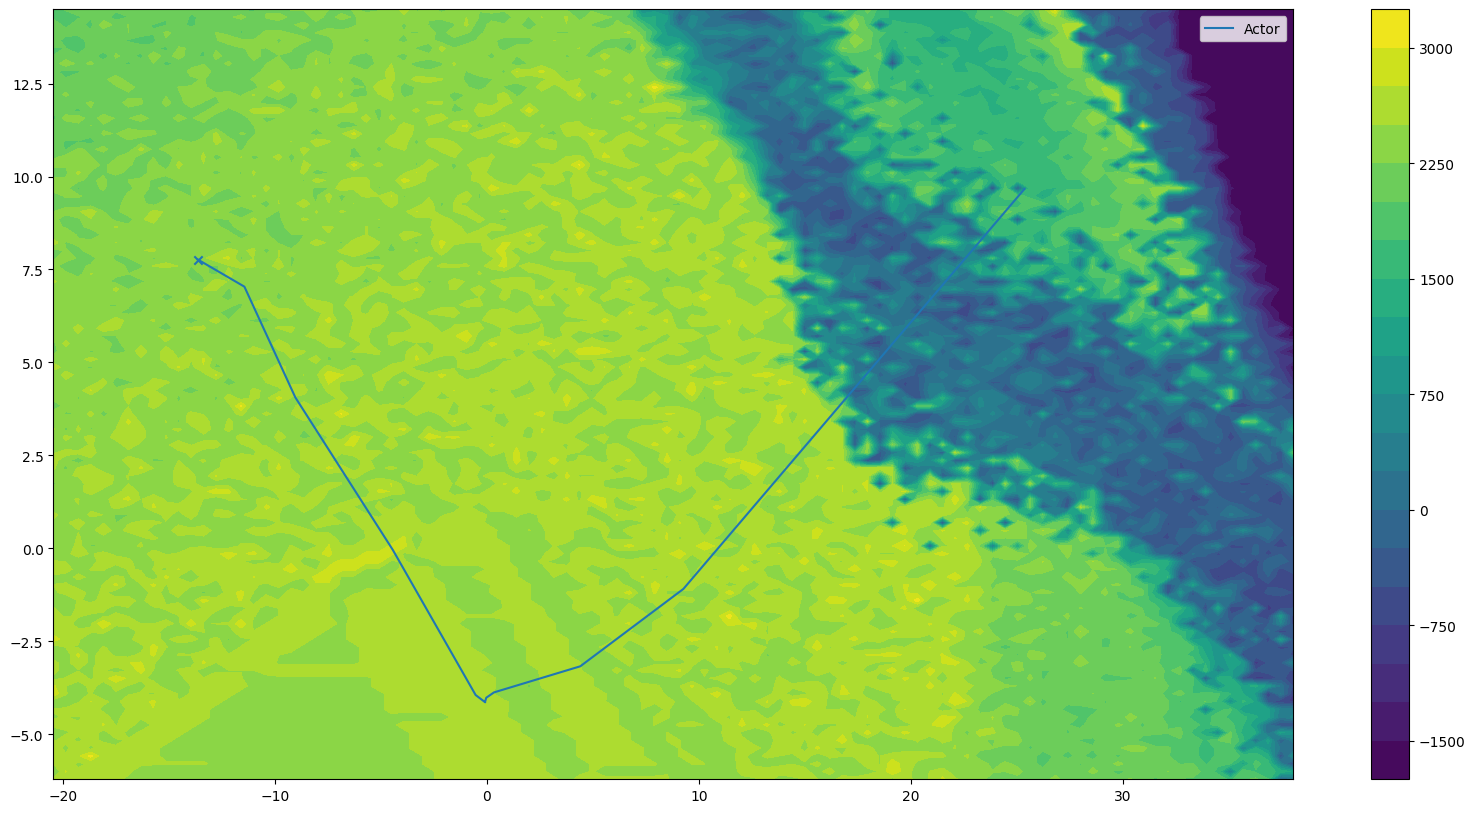

In [105]:
pca.plot()

In [18]:
from landscape_analysis_2d import plot2d, plot3d

In [19]:
def surrogate_eval(genomes, emitter_state):
    random_key = jax.random.PRNGKey(0)

    networks = jax.vmap(emitter.es_emitter.unflatten)(genomes)

    fitnesses, descriptors, extra_scores, random_key = emitter.surrogate_evaluate(
        networks, 
        random_key=random_key,
        emitter_state=emitter_state,
    )

    return fitnesses

In [20]:
nets = jax.vmap()(pca.genomes)

In [21]:
key = jax.random.PRNGKey(0)
fitnesses, descriptors, extra_scores, random_key = scoring_fn(nets, key)

In [22]:
x_grid = x.reshape((n_points, n_points))
y_grid = y.reshape((n_points, n_points))
z_grid = fitnesses.reshape((n_points, n_points))

NameError: name 'x' is not defined

In [ ]:
%matplotlib inline

def plot2d(X, Y, Z, save=None, title="2d interpolation", X_2d=None):
    plt.figure(figsize=(20, 10))
    plt.contourf(X, Y, Z, 20, cmap="viridis")
    plt.legend()
    plt.colorbar()
    f_min, f_max = Z.min(), Z.max()
    plt.clim(f_min, f_max)

    if X_2d is not None:
        prev = None

        for X in X_2d:
            # X = pca.transform(X.reshape(-1, X.shape[-1]))
            plt.scatter(X[0], X[1], color="red")
            if prev is not None:
                # Arrow from prev to current
                plt.arrow(
                    prev[0], prev[1], 
                    X[0] - prev[0], 
                    X[1] - prev[1], 
                    color="red", 
                    # alpha=0.5,
                    )
            prev = X

    plt.xlabel("v1: ES to actor")
    plt.ylabel("v2")
    plt.title(title)
    # same scale both axis
    plt.gca().set_aspect('equal', adjustable='box')
    # save
    if save is not None:
        plt.savefig(save)
    plt.show()

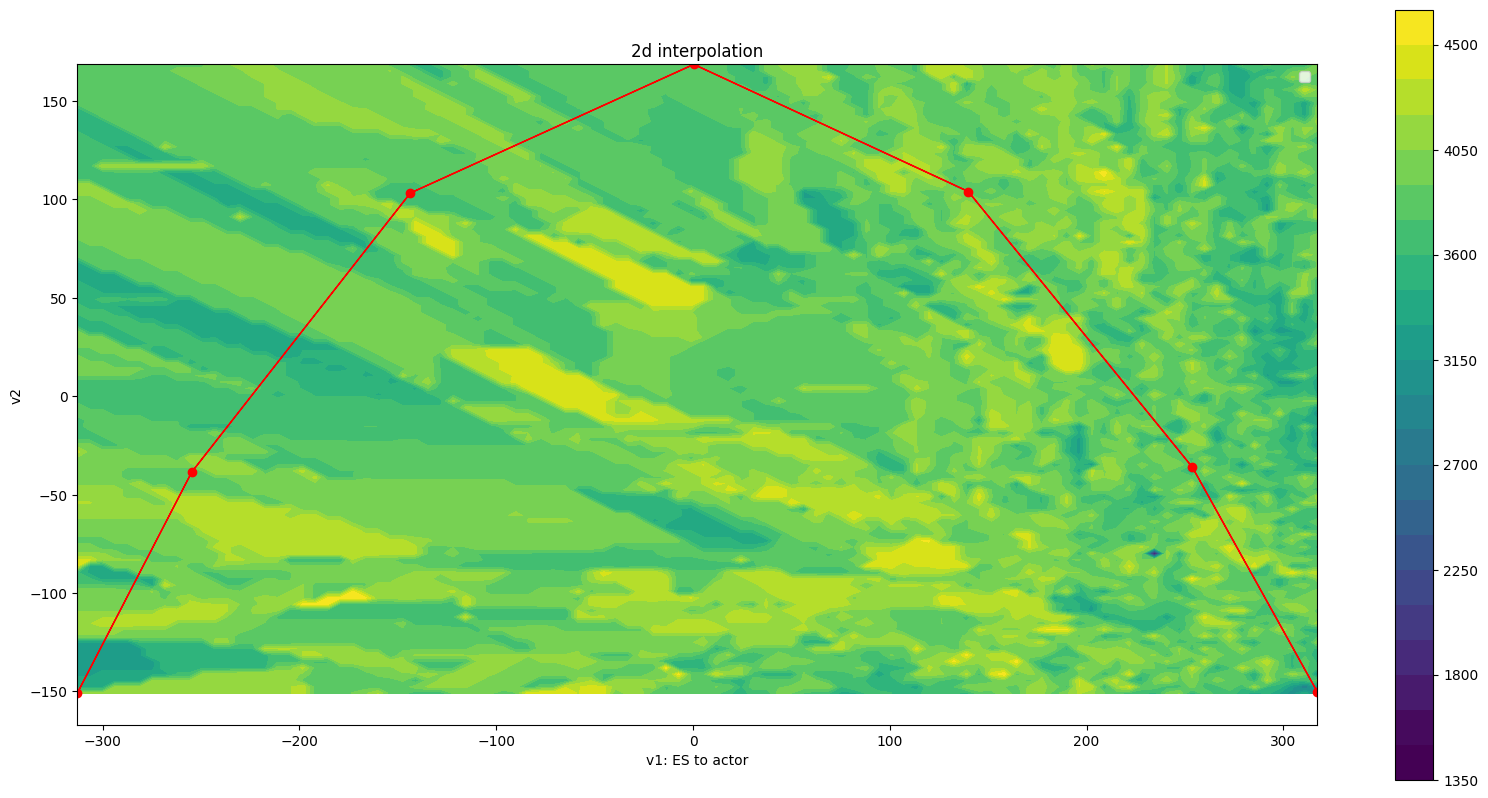

In [94]:
plot2d(x_grid, y_grid, z_grid, X_2d=X_2d)

In [102]:
import plotly.graph_objs as go
import numpy as np
import plotly.offline as pyo

def plot3d(X, Y, Z, save=None):
    # Create a 3D surface plot
    fig = go.Figure(data=[go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale='Viridis'
    )])

    min_z = Z.min()
    max_z = Z.max()

    x_size = X.max() - X.min()
    y_size = Y.max() - Y.min()
    # get as float from jax array
    x_size = float(x_size)
    y_size = float(y_size)

    # Add vertical lines
    fig.add_trace(go.Scatter3d(
        x=[0, 0],
        y=[0, 0],
        z=[min_z, max_z],
        marker=dict(line=dict(width=10)),
        mode='lines',
        name='ES'
    ))

    fig.add_trace(go.Scatter3d(
        x=[1, 1],
        y=[0, 0],
        z=[min_z, max_z],
        marker=dict(line=dict(width=10)),
        mode='lines',
        name='actor'
    ))
    
    # Set the axis labels and title
    fig.update_layout(scene=dict(
        xaxis_title='ES to actor',
        yaxis_title='Y',
        zaxis_title='Fitness',
        aspectratio=dict(x=x_size, y=y_size, z=0.7),
        camera_eye=dict(x=1.2, y=1.2, z=0.6)
    ))

    # Show the plot in a web browser
    if save is not None:
        pyo.plot(fig, filename=save, auto_open=True)
    fig.show()

plot3d(x_grid, y_grid, z_grid)

In [15]:
# get 2 axis of variation
# Get all descriptors
v1, v2 = pca.components_
v1, v2 = jnp.array(v1), jnp.array(v2)

In [16]:
v1.shape

(19718,)

In [17]:
pca.transform(v1.reshape(1, -1)), pca.transform(v2.reshape(1, -1))

(array([[ 318.24823, -150.26405]], dtype=float32),
 array([[ 317.24826, -149.26402]], dtype=float32))

ValueError: shapes (10000,19718) and (2,19718) not aligned: 19718 (dim 1) != 2 (dim 0)

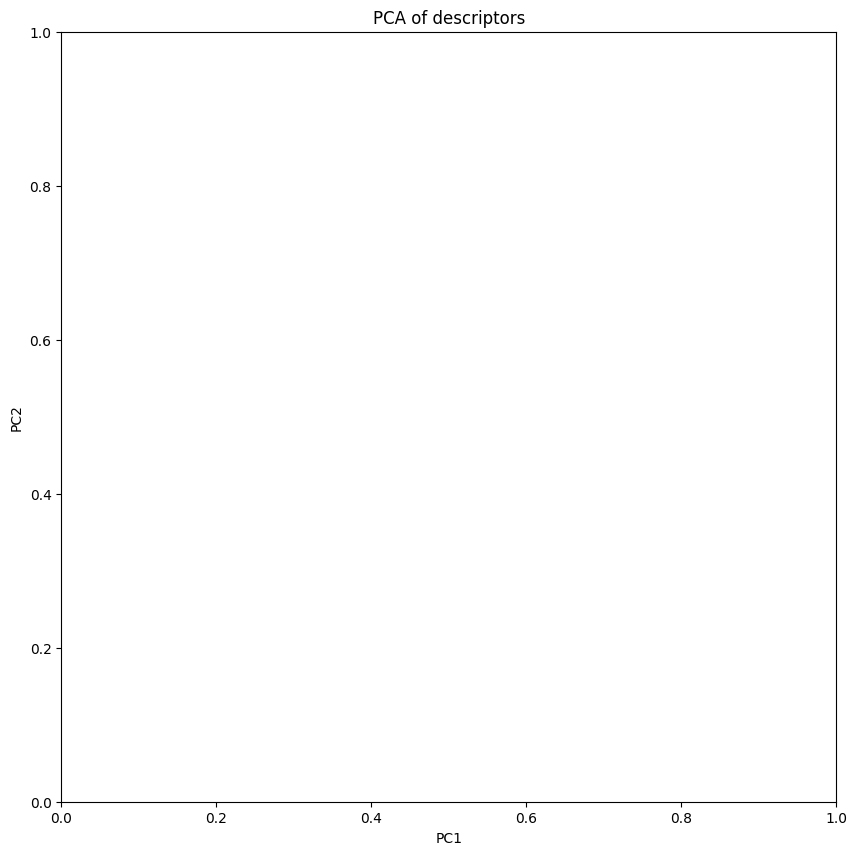

In [30]:
n = 100
# scatter plot with arrows
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("PCA of descriptors")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

# Interpolate as grid
x, y = jnp.meshgrid(
    jnp.linspace(min_v1, max_v1, n), 
    jnp.linspace(min_v2, max_v2, n)
)
x = x.reshape((-1, 1))
y = y.reshape((-1, 1))
genomes = x * v1 + y * v2

# Get in high dim
genomes = pca.inverse_transform(genomes)
genomes.shape